<a href="https://colab.research.google.com/github/OliP82/riesgo-narrativo/blob/main/riesgo_narrativo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¿Cuántas empresas quieres analizar?: 1

Empresa 1
Nombre de la empresa: Wirecard
Ticker bursátil: WDI.HM
¿Cuántos años vas a cargar para esta empresa?: 1

¿A qué año corresponde el informe 1 de Wirecard? (Ej. 2022): 2018
Sube el archivo PDF


Saving Wirecard-Annual-Report-2018.pdf to Wirecard-Annual-Report-2018 (5).pdf


Device set to use cpu
/tmp/ipython-input-7-3416507546.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start=inicio, end=fin)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-7-3416507546.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  precios_lista = [float(p) for p in precios.values]



RESULTADOS DEL INFORME
{
    "empresa": "Wirecard",
    "ticker": "WDI.HM",
    "anio": 2018,
    "fecha_inicio": "2019-01-01",
    "fecha_fin": "2019-03-31",
    "tono": "neutral",
    "confianza": 0.89,
    "similitud": 1.0,
    "opacidad": 1.0,
    "variacion_30d": -25.87,
    "score": 4.890000000000001
}


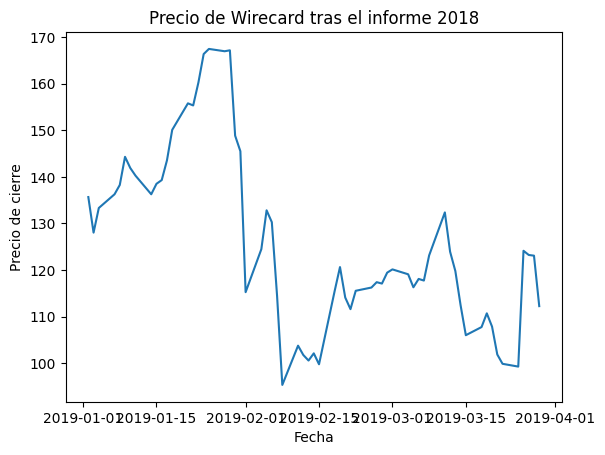

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

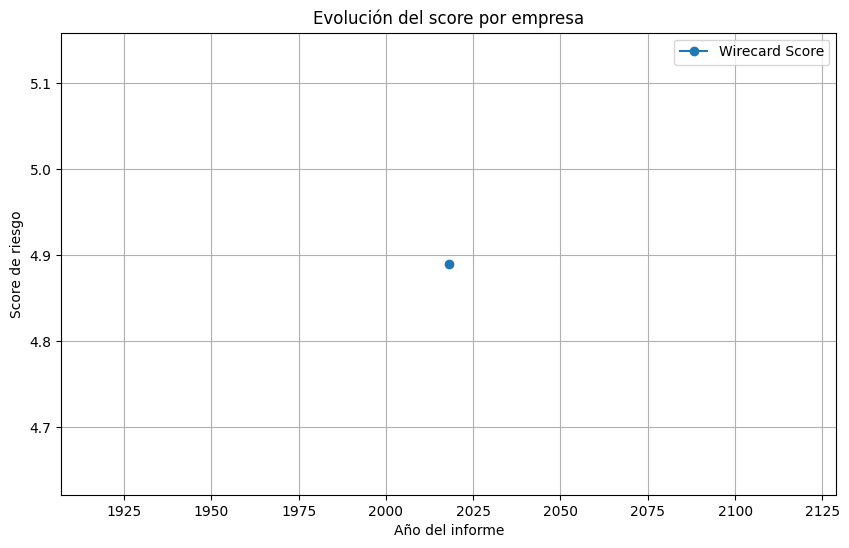

In [ ]:
# Google Colab Notebook: Análisis de Riesgo Narrativo en Informes Financieros

"""
FLUJO GENERAL DEL ANÁLISIS:

1. Instalación de librerías necesarias para el procesamiento de texto, análisis de sentimiento y descarga de precios.
2. Definición de funciones:
   - Extracción de texto desde PDFs.
   - Clasificación del tono narrativo con FinBERT.
   - Comparación de similitud semántica entre informes.
   - Descarga de precios históricos desde Yahoo Finance.
   - Cálculo de un score de riesgo basado en tono, confianza, variación del precio y similitud narrativa.
3. Solicitud iterativa al usuario para subir múltiples informes en PDF por empresa, especificando el ticker y el año del último informe.
4. Procesamiento de cada informe:
   - Se analiza su tono y confianza.
   - Se compara su narrativa con el informe anterior (si aplica).
   - Se descarga la serie de precios posterior al informe y se calcula la variación diaria.
   - Se genera un score de riesgo personalizado para cada informe.
5. Visualización del precio tras cada informe, comparativas interanuales y exportación de resultados a un archivo JSON descargable.
"""

# 1. Instalar dependencias necesarias
!pip install -q transformers pdfplumber yfinance sentence-transformers

# 2. Importar librerías
import pdfplumber
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import yfinance as yf
import matplotlib.pyplot as plt
import json
import pandas as pd
from google.colab import files

# 3. Funciones principales

# Extrae texto completo de un PDF y devuelve una lista de tuplas (número de página, texto).
# Este nuevo formato facilita el análisis por fragmentos o secciones más adelante.
def extraer_texto_pdf(ruta_pdf):
    with pdfplumber.open(ruta_pdf) as pdf:
        return [(i+1, p.extract_text() or "") for i, p in enumerate(pdf.pages)]
    with pdfplumber.open(ruta_pdf) as pdf:
        return "\n".join([p.extract_text() or "" for p in pdf.pages])

def analizar_tono(texto):
    clasificador = pipeline("sentiment-analysis", model="ProsusAI/finbert")
    resultado = clasificador(texto[:512])
    return resultado[0]['label'], resultado[0]['score']

def comparar_similitud(actual, pasado):
    modelo = SentenceTransformer('all-MiniLM-L6-v2')
    emb1 = modelo.encode(actual, convert_to_tensor=True)
    emb2 = modelo.encode(pasado, convert_to_tensor=True)
    return float(util.pytorch_cos_sim(emb1, emb2))

def obtener_precios(ticker, inicio, fin):
    datos = yf.download(ticker, start=inicio, end=fin)
    if datos.empty:
        print("No se encontraron datos para el ticker proporcionado. Introduce la variación manualmente.")
        return None
    return datos['Close']

def score_riesgo(tono, confianza, variacion, similitud):
    score = 0
    if tono == 'negative': score += 2 * confianza
    elif tono == 'neutral': score += 1 * confianza
    if variacion is not None and variacion < -5: score += 2
    if similitud < 0.85: score += 1
    return round(score, 2)

# 4. Carga estructurada por empresa y año
num_empresas = int(input("¿Cuántas empresas quieres analizar?: "))
informes = []

for e in range(num_empresas):
    print(f"\nEmpresa {e+1}")
    empresa = input("Nombre de la empresa: ")
    ticker = input("Ticker bursátil: ")
    num_anios = int(input("¿Cuántos años vas a cargar para esta empresa?: "))

    texto_anterior = None

    for i in range(num_anios):
        anio_reporte = int(input(f"\n¿A qué año corresponde el informe {i+1} de {empresa}? (Ej. 2022): "))
        print("Sube el archivo PDF")
        uploaded = files.upload()
        archivo = list(uploaded.keys())[0]

        fecha_inicio = f"{anio_reporte + 1}-01-01"
        fecha_fin = f"{anio_reporte + 1}-03-31"

        paginas = extraer_texto_pdf(archivo)
        texto = "".join([p[1] for p in paginas])
        tono, confianza = analizar_tono(texto)

        frases_opacas = ["may", "might", "uncertain", "subject to", "potential", "risk", "not guarantee", "could", "assumption"]
        nivel_opacidad = sum(texto.lower().count(palabra) for palabra in frases_opacas)
        riesgo_opacidad = min(nivel_opacidad / 100, 1.0)

        similitud = comparar_similitud(texto, texto_anterior) if texto_anterior else 1.0
        texto_anterior = texto

        precios = obtener_precios(ticker, fecha_inicio, fecha_fin)

        if precios is None:
            variacion = float(input("Introduce manualmente la variación porcentual del precio posterior al informe: "))
        else:
            precios_lista = [float(p) for p in precios.values]
            variacion = [(precios_lista[i] - precios_lista[0]) / precios_lista[0] * 100 for i in range(len(precios_lista))]

        score = score_riesgo(tono, confianza, variacion[30] if isinstance(variacion, list) and len(variacion) > 30 else None, similitud)
        score += round(riesgo_opacidad * 2, 2)

        resultado = {
            "empresa": empresa,
            "ticker": ticker,
            "anio": anio_reporte,
            "fecha_inicio": fecha_inicio,
            "fecha_fin": fecha_fin,
            "tono": tono,
            "confianza": round(confianza, 2),
            "similitud": round(similitud, 2),
            "opacidad": round(riesgo_opacidad, 2),
            "variacion_30d": round(variacion[30], 2) if isinstance(variacion, list) and len(variacion) > 30 else None,
            "score": score
        }

        informes.append({"texto": texto, "resultado": resultado})

        print("\nRESULTADOS DEL INFORME")
        print(json.dumps(resultado, indent=4))

        if precios is not None:
            plt.plot(precios.index, precios.values)
            plt.title(f"Precio de {empresa} tras el informe {anio_reporte}")
            plt.ylabel("Precio de cierre")
            plt.xlabel("Fecha")
            plt.show()

# 5. Exportar resultados y visualizar comparativa final
resultados_finales = [i['resultado'] for i in informes]
with open("resultados_riesgo_multiples.json", "w") as f:
    json.dump(resultados_finales, f, indent=4)

files.download("resultados_riesgo_multiples.json")

df_resultados = pd.DataFrame(resultados_finales)
df_resultados = df_resultados.sort_values(['empresa', 'anio'])

plt.figure(figsize=(10,6))
for empresa in df_resultados['empresa'].unique():
    subset = df_resultados[df_resultados['empresa'] == empresa]
    plt.plot(subset['anio'], subset['score'], marker='o', label=f'{empresa} Score')
plt.title('Evolución del score por empresa')
plt.xlabel('Año del informe')
plt.ylabel('Score de riesgo')
plt.legend()
plt.grid(True)
plt.show()
